In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from glob import glob
import os
import time
import subprocess
import cPickle as pickle
import shutil

import scipy.linalg
import scipy.stats

import residuals
import emcee

import kepler
import threebody

In [30]:
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6,4) # inches :-P
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
plt.viridis()
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 144

In [6]:
import logging
logger = logging.getLogger()

logger.setLevel(logging.DEBUG)
fh = logging.FileHandler("toa-generation.log")
formatter = logging.Formatter(
 '%(asctime)s - %(module)s:%(funcName)s:%(lineno)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

In [7]:
small = False

Set up the Fitter to be used to work with actual TOAs, evaluate the residual, and use it to extract the linear parts.

In [9]:
#F = threebody.Fitter(files="0337+17-anne-2014-02-04c",
#                     tzrmjd_middle='auto',
#                     parfile="0337_tempo2_pm.par",
#                     fit_pos=True,
#                     fit_pm=False,
#                     fit_px=True,
#                     t2_astrometry=True,
#                     kopeikin=True,
#                     ppn_mode='GR')
fpickle = "fake_toas_fitter.pickle"
d = pickle.load(open(fpickle,"rb"))
F = threebody.Fitter(**d)

DEBUG:threebody:base telescope WSRT1400 from list of ['AO1440', 'GBT1500', 'WSRT1400']


In [10]:
resids = F.residuals(F.best_parameters)
print np.sum((resids/F.phase_uncerts)**2)

DEBUG:threebody:Started residuals for {'f0': 365.95336878765835, 'ppn_mode': 'GR', 'shapiro': True, 'asini_i': 1.2175264341415442146, 'eps2_i': -9.1285889042913327283e-05, 'delta_lan': 0.00011199896458130118275, 'eps2_o': -0.0034621052655742367624, 'q_i': 0.13755749187103075547, 'asini_o': 74.672710893931443399, 'j_GBT350': 1.8912917353649655e-05, 'tasc_i': 0.40771694551001255507, 'dgamma': 0.0, 'acosi_o': 91.459500060784388223, 'dbeta': 0.0, 'acosi_i': 1.4907286483746316877, 'tasc_o': 313.93581179378512772, 'eps1_o': 0.03518625777111691392, 'eps1_i': 0.00068722280105428483623, 'j_NCY1400': 0.000675, 'tol': 1e-16, 'j_WSRT350': -3.6063906052781444e-05, 'use_quad': False, 'j_GBT820': 6.712253154451129e-05, 'j_AO327': 6.457616019511097e-05, 'd_DECJ': 2.4779981446904194578e-07, 'delta': 0.0, 'j_AO1440': -0.00055112423718494114149, 'j_AO1350': 5.364017648361716e-05, 'd_RAJ': -6.448690745948047197e-08, 'pb_o': 327.25753845956646629, 'pb_i': 1.6293969339581725185, 'j_GBT1500': -0.000537626829

54301.4772222


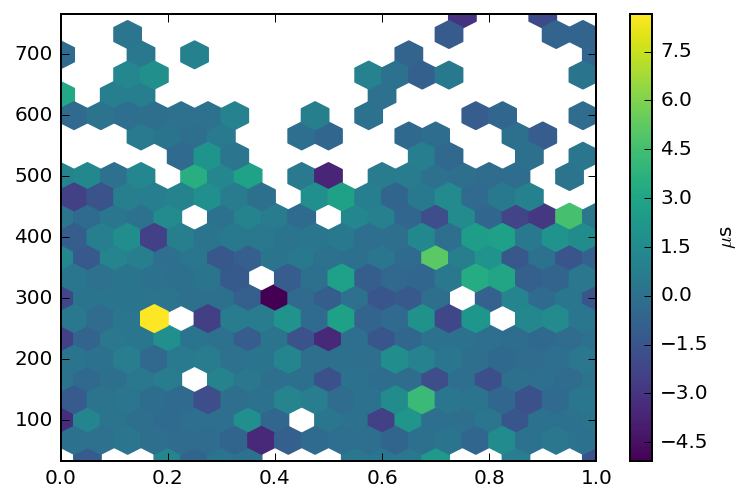

In [32]:
plt.hexbin(
        ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])
             /F.best_parameters['pb_i'])%1, 
        F.mjds,
        C=resids/F.best_parameters['f0']*1e6, gridsize=20)
plt.colorbar().set_label(r"$\mu$s")


In [33]:
mjds = F.mjds-np.dot(F.jmatrix,
        np.array([F.best_parameters[n] for n in F.jnames]))/86400
o_o = threebody.compute_orbit(F.best_parameters, mjds)

DEBUG:threebody:Running compute_orbit with parameter_dict {'f0': 365.95336878765835, 'ppn_mode': 'GR', 'shapiro': True, 'asini_i': 1.2175264341415442146, 'eps2_i': -9.1285889042913327283e-05, 'delta_lan': 0.00011199896458130118275, 'eps2_o': -0.0034621052655742367624, 'q_i': 0.13755749187103075547, 'asini_o': 74.672710893931443399, 'j_GBT350': 1.8912917353649655e-05, 'tasc_i': 0.40771694551001255507, 'dgamma': 0.0, 'acosi_o': 91.459500060784388223, 'dbeta': 0.0, 'acosi_i': 1.4907286483746316877, 'tasc_o': 313.93581179378512772, 'eps1_o': 0.03518625777111691392, 'eps1_i': 0.00068722280105428483623, 'j_NCY1400': 0.000675, 'tol': 1e-16, 'j_WSRT350': -3.6063906052781444e-05, 'use_quad': False, 'j_GBT820': 6.712253154451129e-05, 'j_AO327': 6.457616019511097e-05, 'd_DECJ': 2.4779981446904194578e-07, 'delta': 0.0, 'j_AO1440': -0.00055112423718494114149, 'j_AO1350': 5.364017648361716e-05, 'd_RAJ': -6.448690745948047197e-08, 'pb_o': 327.25753845956646629, 'pb_i': 1.6293969339581725185, 'j_GBT15

In [36]:
linear_part = F.compute_linear_parts(t_psr=o_o['t_psr'])
linear_part['f0']

DEBUG:threebody:Computing linear parts
DEBUG:threebody:Computing linear matrix
DEBUG:threebody:A[0]: [ 1.0  0.043360688  0.00094007464] b[0]: -2.06199474633e-05
DEBUG:threebody:x: [ -5.69131266e+09   2.41864676e+10  -1.02901525e+01]
DEBUG:threebody:residual 54365.341525
DEBUG:threebody:residual RMS 0.000852
DEBUG:threebody:A[0]: [ 1.0  0.043360688  0.00094007464] b[0]: -1.19131304677e-06
DEBUG:threebody:x: [ -1.98264278e-05   9.25803663e-06  -3.87361354e-06]
DEBUG:threebody:residual 54301.477088
DEBUG:threebody:residual RMS 0.000852
DEBUG:threebody:A[0]: [ 1.0  0.043360688  0.00094007464] b[0]: -1.19131304677e-06
DEBUG:threebody:x: [  7.34518260e-21   3.56781004e-20  -1.56888886e-19]
DEBUG:threebody:residual 54301.477088
DEBUG:threebody:residual RMS 0.000852
DEBUG:threebody:Minimizing to find tzrmjd
DEBUG:threebody:done


365.95336308213979731

['j_AO1440', 'j_GBT1500']


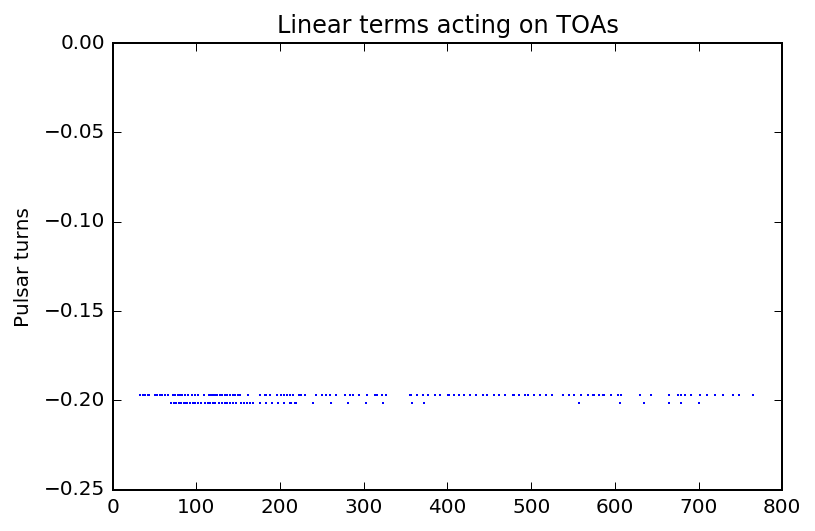

In [37]:
plt.plot(F.mjds, 
    np.dot(F.jmatrix,
      np.array([F.best_parameters[n] for n in F.jnames]))*linear_part['f0'],
    ".",markersize=1)
plt.title("Linear terms acting on TOAs")
plt.ylabel("Pulsar turns")

print F.jnames

These terms are ignored in what comes below; the jumps are fine, but in fact we ignore the position error correction. Let's see how bad that is.

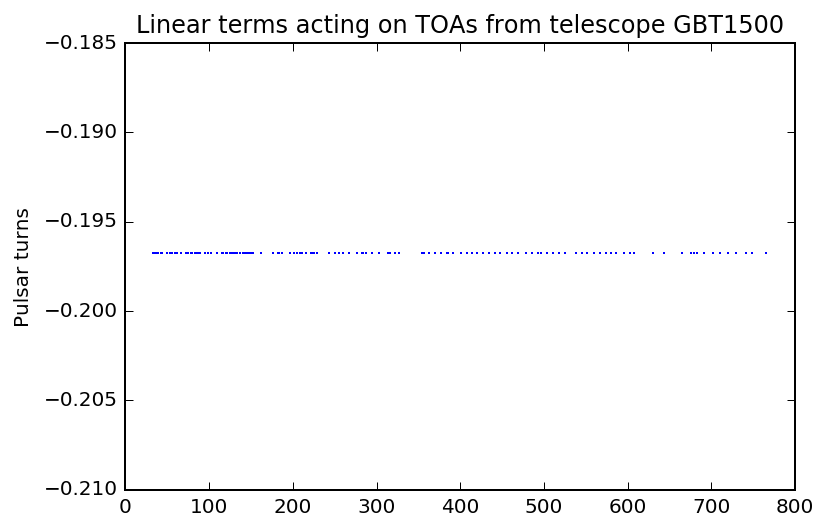

In [38]:
telid = 1
c = F.tels==telid
plt.plot(F.mjds[c], 
    np.dot(F.jmatrix,
      np.array([F.best_parameters[n] 
                for n in F.jnames]))[c]*linear_part['f0'],
    ".",markersize=1)
plt.title("Linear terms acting on TOAs from telescope %s" 
          % F.tel_list[telid])
plt.ylabel("Pulsar turns")


This is the process by which we will evaluate residuals. It's identical to the function F.residuals() except that it doesn't apply the above corrections.

In [39]:
def compute_phases(orbit, p):
    t_psr_s = orbit['t_psr']*86400.
    tzrmjd_s = (p['tzrmjd']+(p['tzrmjd_base']-F.base_mjd))*86400
        
    phase = p['f0']*t_psr_s+p['f1']*t_psr_s**2/2.
    phase -= p['f0']*tzrmjd_s+p['f1']*tzrmjd_s**2/2.
    return phase

In [40]:
phase = compute_phases(o_o, linear_part)

54301.476912408251184

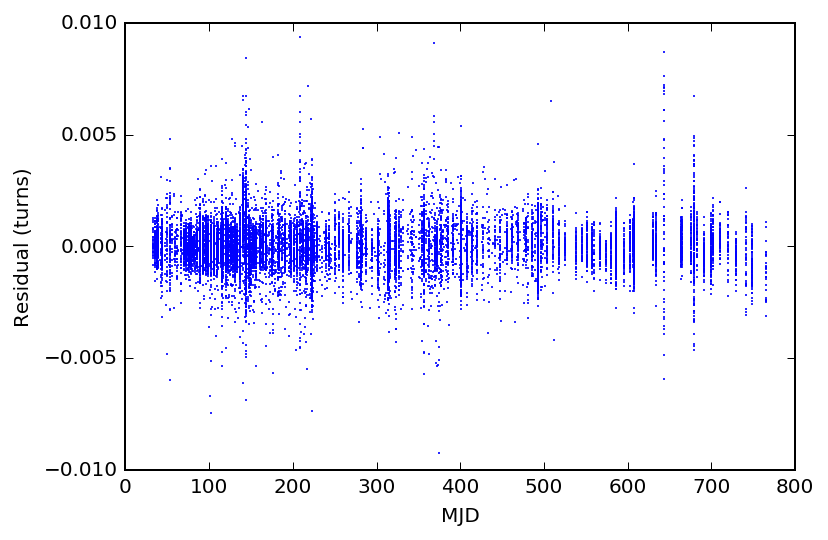

In [42]:
plt.plot(F.mjds, phase-F.pulses, ".",markersize=1)
plt.ylabel("Residual (turns)")
plt.xlabel("MJD")
np.sum(((phase-F.pulses)/F.phase_uncerts)**2)

DEBUG:threebody:Running compute_orbit with parameter_dict {'f0': 365.95336878765835, 'ppn_mode': 'GR', 'shapiro': True, 'asini_i': 1.2175264341415442146, 'eps2_i': -9.1285889042913327283e-05, 'delta_lan': 0.00011199896458130118275, 'eps2_o': -0.0034621052655742367624, 'q_i': 0.13755749187103075547, 'asini_o': 74.672710893931443399, 'j_GBT350': 1.8912917353649655e-05, 'tasc_i': 0.40771694551001255507, 'dgamma': 0.0, 'acosi_o': 91.459500060784388223, 'dbeta': 0.0, 'acosi_i': 1.4907286483746316877, 'tasc_o': 313.93581179378512772, 'eps1_o': 0.03518625777111691392, 'eps1_i': 0.00068722280105428483623, 'j_NCY1400': 0.000675, 'tol': 1e-16, 'j_WSRT350': -3.6063906052781444e-05, 'use_quad': False, 'j_GBT820': 6.712253154451129e-05, 'j_AO327': 6.457616019511097e-05, 'd_DECJ': 2.4779981446904194578e-07, 'delta': 0.0, 'j_AO1440': -0.00055112423718494114149, 'j_AO1350': 5.364017648361716e-05, 'd_RAJ': -6.448690745948047197e-08, 'pb_o': 327.25753845956646629, 'pb_i': 1.6293969339581725185, 'j_GBT15

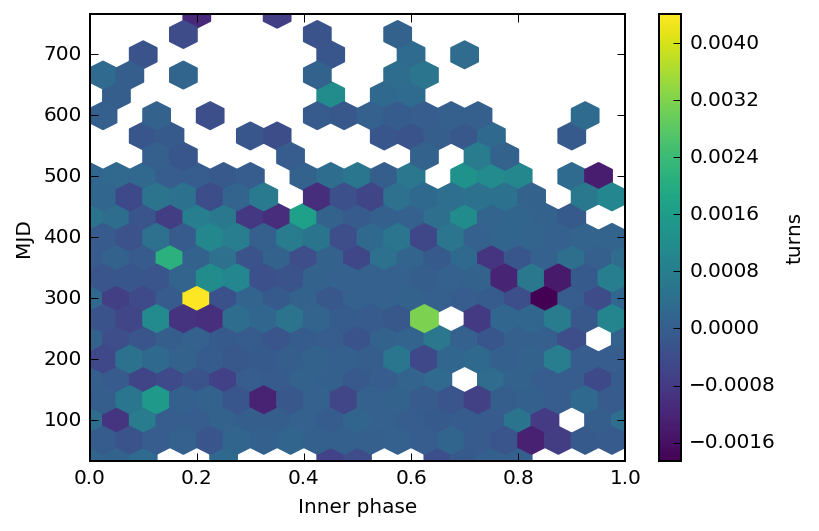

In [43]:
o = threebody.compute_orbit(F.best_parameters, mjds)
obs_phase = compute_phases(o,linear_part)
plt.figure()
plt.hexbin((F.mjds-F.best_parameters['tasc_i'])
               /F.best_parameters['pb_i'] % 1,
           F.mjds,
           C=obs_phase-F.pulses,
           gridsize=20)
plt.xlabel("Inner phase")
plt.ylabel("MJD")
plt.colorbar().set_label("turns")

Set up Fitter without automatic fitting of period etc.

In [44]:
d = pickle.load(open(fpickle,"rb"))
F2 = threebody.Fitter(**d)
F2.tzrmjd_base = linear_part['tzrmjd_base']
F2.best_parameters.update(linear_part)
F2.best_parameters

DEBUG:threebody:base telescope WSRT1400 from list of ['AO1440', 'GBT1500', 'WSRT1400']


{'acosi_i': 1.4907286483746316877,
 'acosi_o': 91.459500060784388223,
 'asini_i': 1.2175264341415442146,
 'asini_o': 74.672710893931443399,
 'd_DECJ': 2.4779981446904194578e-07,
 'd_RAJ': -6.448690745948047197e-08,
 'dbeta': 0.0,
 'delta': 0.0,
 'delta_lan': 0.00011199896458130118275,
 'dgamma': 0.0,
 'eps1_i': 0.00068722280105428483623,
 'eps1_o': 0.03518625777111691392,
 'eps2_i': -9.1285889042913327283e-05,
 'eps2_o': -0.0034621052655742367624,
 'f0': 365.95336308213979731,
 'f1': -2.3557465982822354057e-15,
 'j_AO1350': 5.364017648361716e-05,
 'j_AO1440': -0.00055112423718494114149,
 'j_AO327': 6.457616019511097e-05,
 'j_GBT1500': -0.00053762682928935076775,
 'j_GBT350': 1.8912917353649655e-05,
 'j_GBT820': 6.712253154451129e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.6063906052781444e-05,
 'pb_i': 1.6293969339581725185,
 'pb_o': 327.25753845956646629,
 'ppn_mode': 'GR',
 'q_i': 0.13755749187103075547,
 'shapiro': True,
 'tasc_i': 0.40771694551001255507,
 'tasc_o': 313.9358117937

In [45]:
-2*F2.efac**2*F2.lnprob(F2.best_parameters)

DEBUG:threebody:Started residuals for {'f0': 365.95336308213979731, 'ppn_mode': 'GR', 'shapiro': True, 'asini_i': 1.2175264341415442146, 'eps2_i': -9.1285889042913327283e-05, 'delta_lan': 0.00011199896458130118275, 'eps2_o': -0.0034621052655742367624, 'q_i': 0.13755749187103075547, 'asini_o': 74.672710893931443399, 'j_GBT350': 1.8912917353649655e-05, 'tasc_i': 0.40771694551001255507, 'dgamma': 0.0, 'acosi_o': 91.459500060784388223, 'dbeta': 0.0, 'acosi_i': 1.4907286483746316877, 'tzrmjd_base': 55920, 'tasc_o': 313.93581179378512772, 'eps1_o': 0.03518625777111691392, 'eps1_i': 0.00068722280105428483623, 'j_NCY1400': 0.000675, 'f1': -2.3557465982822354057e-15, 'tol': 1e-16, 'j_WSRT350': -3.6063906052781444e-05, 'use_quad': False, 'j_GBT820': 6.712253154451129e-05, 'j_AO327': 6.457616019511097e-05, 'd_DECJ': 2.4779981446904194578e-07, 'delta': 0.0, 'tzrmjd': 180.00018853360375705, 'j_AO1440': -0.00055112423718494114149, 'j_AO1350': 5.364017648361716e-05, 'd_RAJ': -6.448690745948047197e-08

54301.476912408252897

In [46]:
resids = F2.residuals(F2.best_parameters)
print np.sum((resids/F2.phase_uncerts)**2)

DEBUG:threebody:Started residuals for {'f0': 365.95336308213979731, 'ppn_mode': 'GR', 'shapiro': True, 'asini_i': 1.2175264341415442146, 'eps2_i': -9.1285889042913327283e-05, 'delta_lan': 0.00011199896458130118275, 'eps2_o': -0.0034621052655742367624, 'q_i': 0.13755749187103075547, 'asini_o': 74.672710893931443399, 'j_GBT350': 1.8912917353649655e-05, 'tasc_i': 0.40771694551001255507, 'dgamma': 0.0, 'acosi_o': 91.459500060784388223, 'dbeta': 0.0, 'acosi_i': 1.4907286483746316877, 'tzrmjd_base': 55920, 'tasc_o': 313.93581179378512772, 'eps1_o': 0.03518625777111691392, 'eps1_i': 0.00068722280105428483623, 'j_NCY1400': 0.000675, 'f1': -2.3557465982822354057e-15, 'tol': 1e-16, 'j_WSRT350': -3.6063906052781444e-05, 'use_quad': False, 'j_GBT820': 6.712253154451129e-05, 'j_AO327': 6.457616019511097e-05, 'd_DECJ': 2.4779981446904194578e-07, 'delta': 0.0, 'tzrmjd': 180.00018853360375705, 'j_AO1440': -0.00055112423718494114149, 'j_AO1350': 5.364017648361716e-05, 'd_RAJ': -6.448690745948047197e-08

54301.4769124


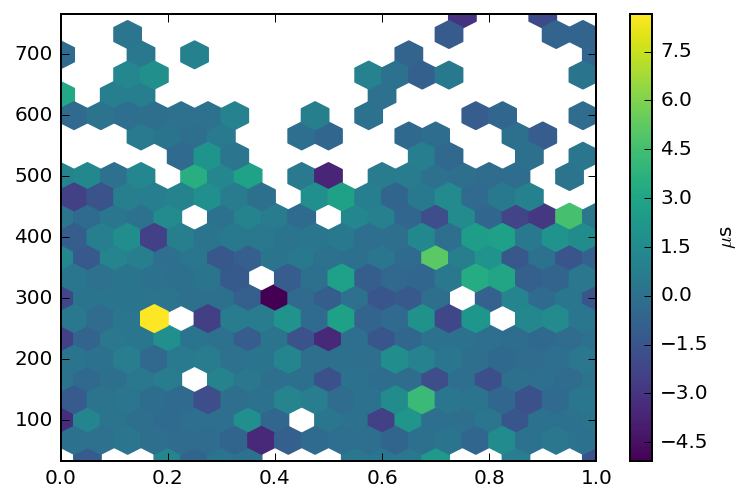

In [47]:
plt.hexbin(
        ((F2.mjds-F2.base_mjd-F2.best_parameters['tasc_i'])
             /F2.best_parameters['pb_i'])%1, 
        F2.mjds,
        C=resids/F2.best_parameters['f0']*1e6, gridsize=20)
plt.colorbar().set_label(r"$\mu$s")

In [48]:
if small:
    length_days = 800 # 1000
    per_day = 45 # 1000
else:
    length_days = 10000
    per_day = 100
times = np.linspace(1,
                    length_days,
                    length_days*per_day).astype(np.float128)


In [49]:
o = threebody.compute_orbit(F.best_parameters, times)

DEBUG:threebody:Running compute_orbit with parameter_dict {'f0': 365.95336878765835, 'ppn_mode': 'GR', 'shapiro': True, 'asini_i': 1.2175264341415442146, 'eps2_i': -9.1285889042913327283e-05, 'delta_lan': 0.00011199896458130118275, 'eps2_o': -0.0034621052655742367624, 'q_i': 0.13755749187103075547, 'asini_o': 74.672710893931443399, 'j_GBT350': 1.8912917353649655e-05, 'tasc_i': 0.40771694551001255507, 'dgamma': 0.0, 'acosi_o': 91.459500060784388223, 'dbeta': 0.0, 'acosi_i': 1.4907286483746316877, 'tasc_o': 313.93581179378512772, 'eps1_o': 0.03518625777111691392, 'eps1_i': 0.00068722280105428483623, 'j_NCY1400': 0.000675, 'tol': 1e-16, 'j_WSRT350': -3.6063906052781444e-05, 'use_quad': False, 'j_GBT820': 6.712253154451129e-05, 'j_AO327': 6.457616019511097e-05, 'd_DECJ': 2.4779981446904194578e-07, 'delta': 0.0, 'j_AO1440': -0.00055112423718494114149, 'j_AO1350': 5.364017648361716e-05, 'd_RAJ': -6.448690745948047197e-08, 'pb_o': 327.25753845956646629, 'pb_i': 1.6293969339581725185, 'j_GBT15

In [50]:
phase = compute_phases(o,linear_part)

In [51]:
dphase = phase - np.round(phase)
times2 = times-dphase/linear_part['f0']/86400.
print np.amax(np.abs(dphase))

0.499999828637


In [52]:
o2 = threebody.compute_orbit(F.best_parameters, times2)

DEBUG:threebody:Running compute_orbit with parameter_dict {'f0': 365.95336878765835, 'ppn_mode': 'GR', 'shapiro': True, 'asini_i': 1.2175264341415442146, 'eps2_i': -9.1285889042913327283e-05, 'delta_lan': 0.00011199896458130118275, 'eps2_o': -0.0034621052655742367624, 'q_i': 0.13755749187103075547, 'asini_o': 74.672710893931443399, 'j_GBT350': 1.8912917353649655e-05, 'tasc_i': 0.40771694551001255507, 'dgamma': 0.0, 'acosi_o': 91.459500060784388223, 'dbeta': 0.0, 'acosi_i': 1.4907286483746316877, 'tasc_o': 313.93581179378512772, 'eps1_o': 0.03518625777111691392, 'eps1_i': 0.00068722280105428483623, 'j_NCY1400': 0.000675, 'tol': 1e-16, 'j_WSRT350': -3.6063906052781444e-05, 'use_quad': False, 'j_GBT820': 6.712253154451129e-05, 'j_AO327': 6.457616019511097e-05, 'd_DECJ': 2.4779981446904194578e-07, 'delta': 0.0, 'j_AO1440': -0.00055112423718494114149, 'j_AO1350': 5.364017648361716e-05, 'd_RAJ': -6.448690745948047197e-08, 'pb_o': 327.25753845956646629, 'pb_i': 1.6293969339581725185, 'j_GBT15

In [53]:
phase2 = compute_phases(o2,linear_part)

In [54]:
dphase2 = phase2 - np.round(phase2)
times3 = times2-dphase2/linear_part['f0']/86400.
print np.amax(np.abs(dphase2))

3.5434961319e-05


In [55]:
print np.std(dphase), np.std(dphase2), len(times3)

0.288770403277 1.15976717838e-05 1000000


In [56]:
if True:
    fake_times = times3
    fake_pulses = np.round(phase2)
else:
    fake_times = F.mjds - F.base_mjd
    #fake_times = mjds
    fake_pulses = F.pulses

In [57]:
obs_phase = compute_phases(o_o,linear_part)

(492, 493.5)

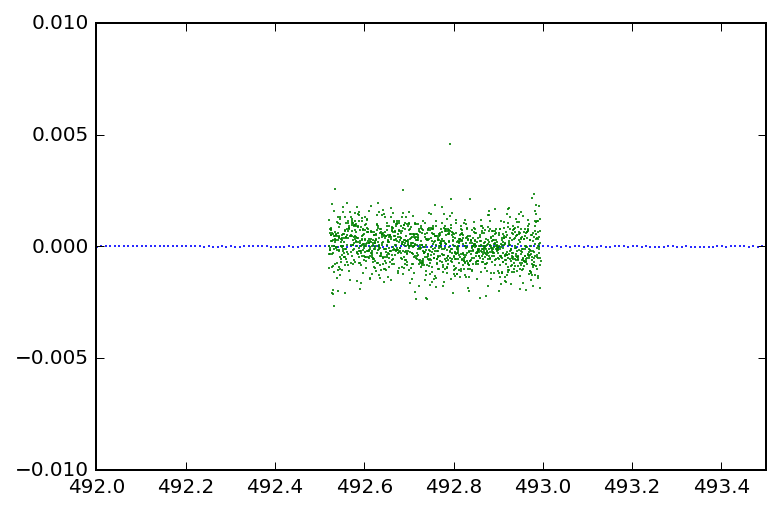

In [58]:
plt.plot(fake_times, phase2-fake_pulses, ".", markersize=1)
plt.plot(F2.mjds, obs_phase-F2.pulses, ".", markersize=1)
plt.xlim(56412-F2.base_mjd, 56413.5-F2.base_mjd)

In [59]:
def tcb_to_tdb_wiki(tcb):
    LB = 1.550519768e-8
    TDB0 = -6.55e-5
    T0_JD = 2443144.5003725
    T0_MJD = 43144.0003725
    tdb = tcb - LB*(tcb-T0_MJD) + TDB0/86400.
    return tdb


In [60]:
def tcb_to_tdb(tcb):
    Lb=1.550519768e-8
    tdb0=-6.55e-5
    t0=43144.0003725-F.base_mjd
    return tcb-Lb*(tcb-t0)+tdb0
base_mjd_tdb = tcb_to_tdb_wiki(F.base_mjd)-tcb_to_tdb(0)
base_mjd_tdb

55920.00006549924

In [61]:
for t in [0,1,10,100,1000]:
    print tcb_to_tdb_wiki(F.base_mjd+t), tcb_to_tdb(t)+base_mjd_tdb

55919.9998019 55919.9998019
55920.9998019 55920.9998019
55929.9998017 55929.9998017
56019.9998004 56019.9998004
56919.9997864 56919.9997864


In [62]:
def write_fake_tim(name, fake_times, fake_pulses, base):
    with open(name+".tim","wt") as f:
        with open(name+".pulses","wt") as fp:
            for t, n in zip(fake_times, 
                            fake_pulses):
                tt = t+(base-np.floor(base))
                t_base = np.floor(base) + np.floor(tt)
                t_frac = tt-np.floor(tt)
                strtoa = repr(int(t_base))+("%.100f"%t_frac)[1:]
                if abs(float(strtoa)-base-t)>1e-5:
                    raise ValueError("t: %s strtoa: %s" % (t,strtoa))
                f.write("@             999999.999 %19s     3.00\n" % strtoa[:19])
                fp.write("%d\n" % n)
        

In [63]:
len(fake_times)

1000000

In [64]:
write_fake_tim("fake", 
               np.array([tcb_to_tdb(t) for t in fake_times]),
               fake_pulses, base_mjd_tdb)
write_fake_tim("faket2", fake_times, fake_pulses, F.base_mjd)

In [65]:
t = fake_times[-100]
t_base = 0*F.base_mjd + np.floor(t)
t_frac = t-np.floor(t)
strtoa = repr(int(t_base))+("%.100f"%t_frac)[1:]

print (threebody.mjd_fromstring(strtoa)-0*F.base_mjd - t)*86400*1e8
print (threebody.mjd_fromstring("%19s" % strtoa)-0*F.base_mjd - t)*86400*1e8


0.0
0.0


Let's see what we get when we load these fake TOAs back in. We have to use the t2 version because we're using tempo2 and a TCB-based par file.

In [67]:
d = pickle.load(open(fpickle,"rb"))
d['files'] = 'faket2'
try:
    os.unlink(d['files']+"_"+d['parfile']+".out")
except OSError:
    pass
F3 = threebody.Fitter(**d)
F3.tzrmjd_base = F2.tzrmjd_base
F3.best_parameters = F2.best_parameters.copy()
d

CalledProcessError: Command '['tempo2', '-nobs', '1000100', '-npsr', '1', '-output', 'general2', '-s', 'OUTPUT {bat} {freq} {err} {d_RAJ} {d_DECJ} {d_PX} {d_PMRA} {d_PMDEC}\n', '-f', '0337_tempo2_px_optical.par', 'faket2.tim']' returned non-zero exit status -11

In [ ]:
F3.best_parameters

In [ ]:
plt.plot(fake_times, (F3.mjds-fake_times)*86400*1e6, 
         ".", markersize=1)
plt.ylabel(r"$\mu$s")

In [ ]:
np.all(F3.pulses == fake_pulses)

In [ ]:
r3 = F3.residuals(F3.best_parameters)
len(r3)

In [ ]:
plt.figure()
plt.hexbin((F3.mjds-F3.best_parameters['tasc_i'])
               /F3.best_parameters['pb_i'] % 1,
           F3.mjds,
           C=r3)
plt.xlabel("Inner phase")
plt.ylabel("MJD")
plt.colorbar().set_label("turns")

In [ ]:
o = threebody.compute_orbit(F3.best_parameters, mjds)
obs_phase = compute_phases(o,linear_part)
plt.figure()
plt.hexbin((F.mjds-F3.best_parameters['tasc_i'])
               /F3.best_parameters['pb_i'] % 1,
           F.mjds,
           C=obs_phase-F.pulses,
           gridsize=20)
plt.xlabel("Inner phase")
plt.ylabel("MJD")
plt.colorbar().set_label("turns")

Let's see how the MvK ephemeris likes these TOAs.

In [39]:
#parfile = "0337_full_iterated_nofit_2-2.par"
#parfile = "0337+17_MvK_nofit.par"
parfile = "0337+17_MvK_long_2014-09-26.par"
c = ["tempo", 
     "-m", str(len(fake_times)+1000),
                       "-f", parfile, 
                       "-ni", "fake.pulses", 
                       "fake.tim"]
print " ".join(c)
subprocess.check_call(c)


tempo -m 1001000 -f 0337+17_MvK_long_2014-09-26.par -ni fake.pulses fake.tim


0

In [40]:
r = residuals.read_residuals()
print len(r.bary_TOA)

1000000


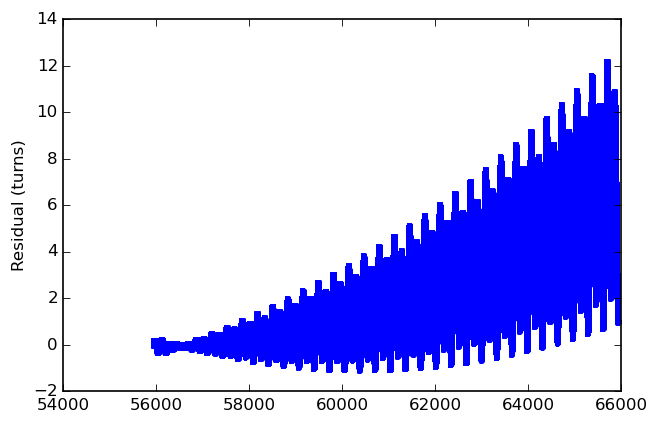

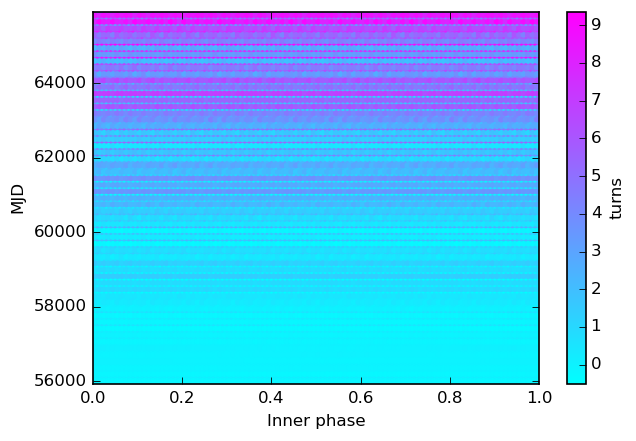

In [41]:
plt.plot(r.bary_TOA, r.prefit_phs-r.prefit_phs[0],'.')
plt.ylabel("Residual (turns)")
#plt.gca().set_yscale('symlog',linthreshy=1e-2)

plt.figure()
plt.hexbin((r.bary_TOA-F.base_mjd-F.best_parameters['tasc_i'])
               /F.best_parameters['pb_i'] % 1,
           r.bary_TOA,
           #(r.bary_TOA-F.base_mjd-F.best_parameters['tasc_o'])/F.best_parameters['pb_o'],
           C=r.prefit_phs-r.prefit_phs[0])
plt.xlabel("Inner phase")
plt.ylabel("MJD")
plt.colorbar().set_label(r"turns")
plt.savefig("fake-resids-pre.pdf")

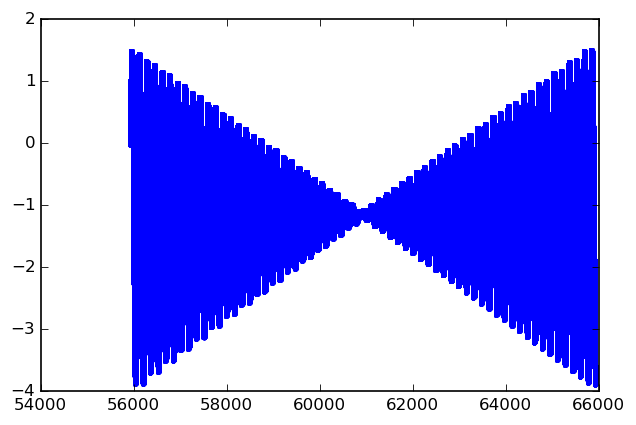

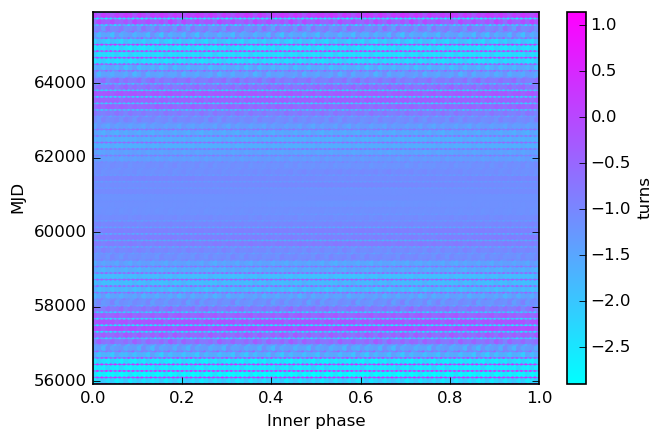

In [42]:
plt.plot(r.bary_TOA, r.postfit_phs-r.postfit_phs[0],'.')
#plt.gca().set_yscale('symlog',linthreshy=1e-2)

plt.figure()
plt.hexbin((r.bary_TOA-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'] % 1,
           r.bary_TOA, #(r.bary_TOA-F.base_mjd-F.best_parameters['tasc_o'])/F.best_parameters['pb_o'],
           C=r.postfit_phs-r.postfit_phs[0])
plt.xlabel("Inner phase")
plt.ylabel("MJD")
plt.colorbar().set_label(r"turns")
plt.savefig("fake-resids-post.pdf")

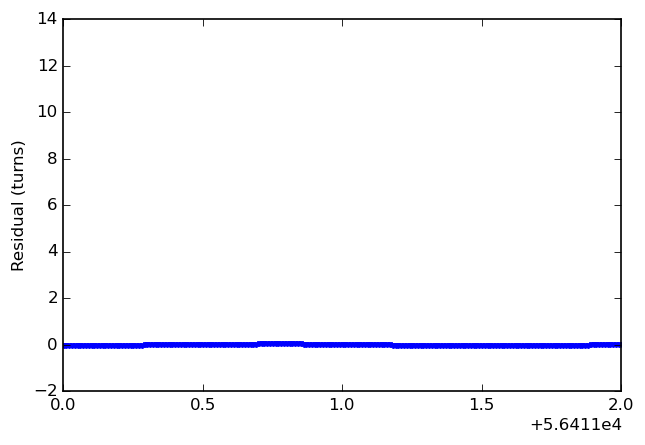

In [43]:
plt.plot(r.bary_TOA, r.prefit_phs-r.prefit_phs[0],'.')
plt.ylabel("Residual (turns)")
plt.xlim(56411,56413)
#plt.gca().set_yscale('symlog',linthreshy=1e-2)

if False:
    plt.figure()
    plt.hexbin((r.bary_TOA-F.base_mjd-F.best_parameters['tasc_i'])
               /F.best_parameters['pb_i'] % 1,
           r.bary_TOA,
           #(r.bary_TOA-F.base_mjd-F.best_parameters['tasc_o'])/F.best_parameters['pb_o'],
           C=r.prefit_phs-r.prefit_phs[0])
    plt.xlabel("Inner phase")
    plt.ylabel("MJD")
    plt.colorbar().set_label(r"turns")
    plt.xlim(56411,56413)


Let's see how a par file fitted to these fake TOAs likes the real TOAs.

In [45]:
F.files

'0337+17-anne-2014-02-04c'

In [46]:
MJD = 56412
length = 10
timfile = 'toas/gbt/L-band-scott-2014-02-04-nojump.tim'

subprocess.check_call(["python", 
                       "fit_segment.py",
                       "--length", str(length), 
                       "--fixedbtx", 
                       str(MJD)])
rfit = residuals.read_residuals()
shutil.copy("J0337+17.par", "J0337+17-copy.par")

In [47]:
subprocess.check_call(["tempo", 
                       "-f", "J0337+17-copy.par", 
                       timfile])
r = residuals.read_residuals()

In [48]:
subprocess.check_call(["tempo", 
                       "-f", "J0337+17-copy.par", 
                       "fake.tim"])
rfake = residuals.read_residuals()

In [49]:
subprocess.check_call(["tempo", 
                       "-f", "J0337+17-copy.par", 
                       "temp.tim"])
rtemp = residuals.read_residuals()

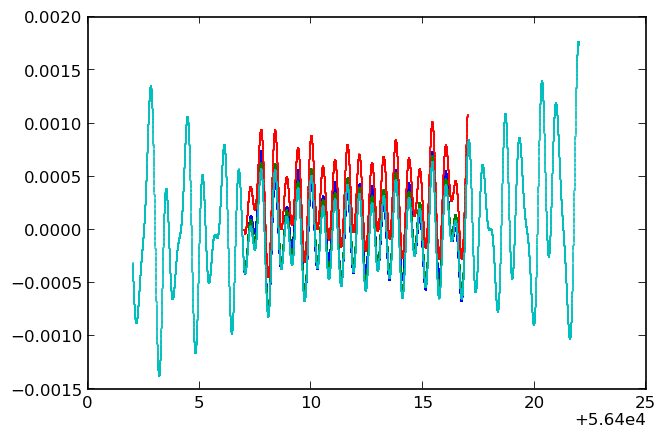

In [50]:
c = np.abs(rfit.bary_TOA-MJD)<length
phs = rfit.prefit_phs[c].copy()
phs -= phs.mean()
plt.plot(rfit.bary_TOA[c], phs, ".", markersize=1)
plt.plot(rfit.bary_TOA[c], rfit.postfit_phs[c], ".", markersize=1)
c = np.abs(rtemp.bary_TOA-MJD)<length
plt.plot(rtemp.bary_TOA[c], rtemp.prefit_phs[c], ".", markersize=1)

c = np.abs(rfake.bary_TOA-MJD)<length
phs = rfake.prefit_phs[c].copy()
phs -= phs.mean()
plt.plot(rfake.bary_TOA[c], phs, ".", markersize=1)


In [51]:
def rewrap(x, c):
    return (x+c)%1 - c

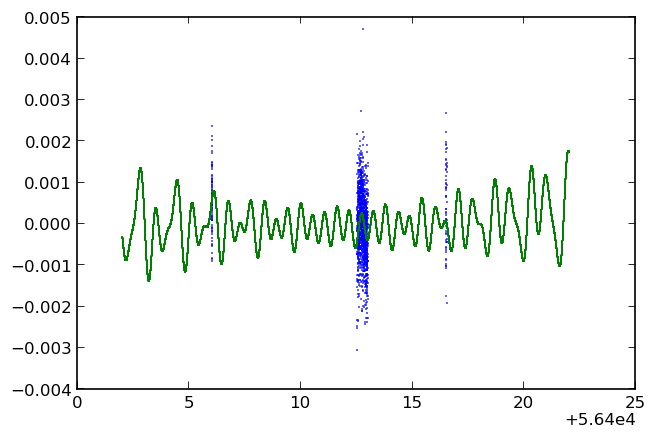

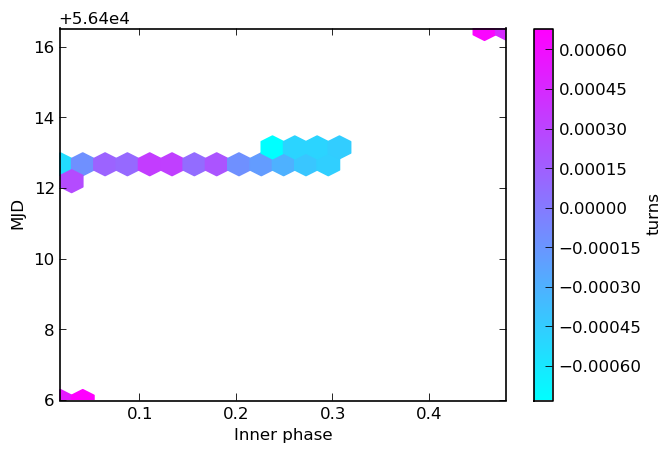

In [52]:
c = np.abs(r.bary_TOA-MJD)<length
phs = rewrap(r.prefit_phs[c],0.0)
phs -= phs.mean()
plt.plot(r.bary_TOA[c], phs, ".", markersize=1)

c2 = np.abs(rfake.bary_TOA-MJD)<length
phs2 = rfake.prefit_phs[c2]
phs2 -= phs2.mean()
plt.plot(rfake.bary_TOA[c2], phs2, 
         ".", markersize=1)

plt.figure()
plt.hexbin((r.bary_TOA[c]-F.base_mjd-F.best_parameters['tasc_i'])
               /F.best_parameters['pb_i'] % 1,
           r.bary_TOA[c], 
           C=phs,
           gridsize=20)
plt.xlabel("Inner phase")
plt.ylabel("MJD")
plt.colorbar().set_label("turns")


In [53]:
parfile = "0337+17_MvK_nofit.par"
subprocess.check_call(["tempo", 
                       "-f", parfile, 
                       timfile])
r = residuals.read_residuals()

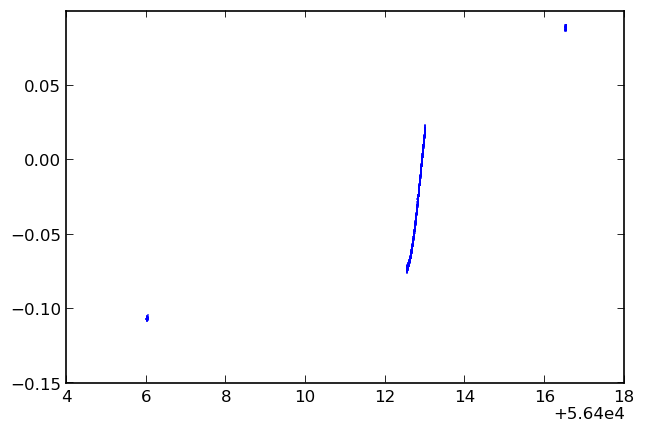

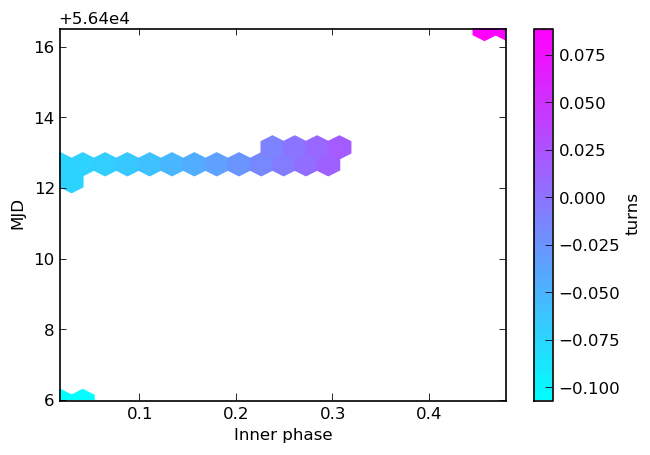

In [54]:
c = np.abs(r.bary_TOA-MJD)<length
plt.plot(r.bary_TOA[c], r.prefit_phs[c], ".", markersize=1)
plt.figure()
plt.hexbin((r.bary_TOA[c]-F.base_mjd-F.best_parameters['tasc_i'])
               /F.best_parameters['pb_i'] % 1,
           r.bary_TOA[c], 
           C=r.prefit_phs[c],
           gridsize=20)
plt.xlabel("Inner phase")
plt.ylabel("MJD")
plt.colorbar().set_label("turns")


Comparing TOAs, fake and real, using the MvK ephemeris

In [ ]:
parfile = "0337+17_MvK_nofit.par"
#parfile = "0337_tempo2_px_optical_t1.par"
subprocess.check_call(["tempo", 
                       "-f", parfile, 
                       "-ni", "fake.pulses", 
                       "fake.tim"])
rfake = residuals.read_residuals()
print len(rfake.bary_TOA)

In [ ]:
subprocess.check_call(["tempo", 
                       "-f", parfile, 
                       "-ni", F.files + ".pulses", 
                       F.files + ".tim"])
rreal = residuals.read_residuals()
print len(rreal.bary_TOA)

In [ ]:
plt.plot(rreal.bary_TOA, rreal.prefit_phs-np.mean(rreal.prefit_phs), 
         ".", markersize=1)
plt.plot(rfake.bary_TOA, rfake.prefit_phs-np.mean(rfake.prefit_phs), 
         ".", markersize=1)


In [ ]:
plt.plot(rreal.bary_TOA, rreal.prefit_phs-np.mean(rreal.prefit_phs), 
         ".", markersize=1)
plt.plot(rfake.bary_TOA, rfake.prefit_phs-np.mean(rfake.prefit_phs)+1, 
         ".", markersize=1)
plt.xlim(MJD+0.5, MJD+1.5)
#plt.ylim(-1,0)

### Compare the barycentered TOAs produced using tempo and tempo2

In [ ]:
t1toa = np.copy(rreal.bary_TOA)
t1toa = np.sort(t1toa)
dmjds = np.array([tcb_to_tdb(m) for m in F.mjds])+base_mjd_tdb
diff = (t1toa-dmjds)*86400
print np.mean(diff)
plt.plot(t1toa, diff, 
         ".", markersize=1)
plt.ylabel(r"s")
plt.xlabel("MJD")
plt.title("tempo minus tempo2 barycentered TOAs")
plt.savefig("barydiff.pdf")

Comparing barycentering

In [ ]:
tempo2_program = '/home/aarchiba/software/tempo2/tempo2/tempo2'
tempo2_dir = '/home/aarchiba/software/tempo2/t2dir'

In [ ]:
par_t2 = """
PSR              J0337+17    
RAJ      03:37:43.826099
DECJ      17:15:14.826651
PX                    0.77
PMRA                  3.56
PMDEC                -3.90
F0    365.9533436144258189  0  0.0000000000656904
F1      7.833539631670D-15  0  1.490959143049D-17
PEPOCH        56500.000000
DM               21.313000
SOLARN0              10.00
EPHEM             DE421
CLK               TT(TAI)
TZRMJD  56100.13622674904492
TZRFRQ            1379.999
TZRSITE                  j
"""
compare_tim = F.files+".tim"

In [ ]:
par_t1 = """
PSR              J0337+17    
RAJ      03:37:43.826099
DECJ      17:15:14.826651
PX                    0.77
PMRA                  3.56
PMDEC                -3.90
F0    365.9533436144258189  0  0.0000000000656904
F1      7.833539631670D-15  0  1.490959143049D-17
PEPOCH        56500.000000
DM               21.313000
SOLARN0              10.00
EPHEM             DE421
TZRMJD  56100.13622674904492
TZRFRQ            1379.999
TZRSITE                  j
"""

In [ ]:
def tempo_resids(par):
    temppar = "temp.par"
    with open(temppar, "wt") as f:
        f.write(par)
    e = os.environ.copy()
    e['TEMPO'] = '/tmp/a'
    subprocess.check_call(["tempo", "-f", temppar, compare_tim], env=e)
    r = residuals.read_residuals()
    return r.bary_TOA, r

def tempo2_resids(par):
    temppar = "temp.par"
    with open(temppar, "wt") as f:
        f.write(par)
    e = os.environ.copy()
    e['TEMPO2'] = tempo2_dir
    o = subprocess.check_output(
        [tempo2_program,
         "-output", "general2",
         "-s", "OUTPUT {bat}\n",
         "-f", temppar, 
         compare_tim], env=e)
    r = []
    for l in o.split("\n"):
        if not l.startswith("OUTPUT"):
            continue
        r.append(float(l.split()[1]))
    return np.array(r)

    

In [ ]:
r1, r = tempo_resids(par_t1)

In [ ]:
r2 = tempo2_resids(par_t1)

In [ ]:
tcb_to_tdb_wiki(F.base_mjd), tcb_to_tdb(0)+F.base_mjd

In [ ]:
plt.plot(r1, (tcb_to_tdb_wiki(r2)-r1)*86400*1e6,
         ".",markersize=1)
plt.ylabel(r"$\mu$s")
plt.xlabel("MJD")
plt.title("tempo2 barycentered TOAs minus tempo")
plt.savefig("barydiff-simple.pdf")

In [ ]:
plt.plot(r.bary_freq, (tcb_to_tdb_wiki(r2)-r1)*86400*1e6,
         ".",markersize=1)
plt.ylabel(r"$\mu$s")


In [ ]:
par_t2_tdb = """
PSR              J0337+17    
RAJ      03:37:43.826099
DECJ      17:15:14.826651
PX                    0.77
PMRA                  3.56
PMDEC                -3.90
F0    365.9533436144258189  0  0.0000000000656904
F1      7.833539631670D-15  0  1.490959143049D-17
PEPOCH        56500.000000
DM               21.313000
SOLARN0              10.00
EPHEM             DE421
TZRMJD  56100.13622674904492
TZRFRQ            1379.999
TZRSITE                  j
UNITS TDB
"""

In [ ]:
r1, _ = tempo_resids(par_t2_tdb)

In [ ]:
r3 = tempo2_resids(par_t2_tdb)

In [ ]:
plt.plot(r1, (r3-r1)*86400*1e6,
         ".",markersize=1)
plt.ylabel(r"$\mu$s")
plt.xlabel("MJD")
plt.title("tempo2 barycentered TOAs minus tempo")
plt.savefig("barydiff-simple.pdf")

In [ ]:
par_t2_match = """
PSR              J0337+17    
RAJ      03:37:43.826099
DECJ      17:15:14.826651
PX                    0.77
PMRA                  3.56
PMDEC                -3.90
F0    365.9533436144258189  0  0.0000000000656904
F1      7.833539631670D-15  0  1.490959143049D-17
PEPOCH        56500.000000
DM               21.313000
SOLARN0              10.00
EPHEM             DE421
TZRMJD  56100.13622674904492
TZRFRQ            1379.999
TZRSITE                  j
UNITS TDB
CLK                 TT(TAI)
UNITS               TDB
TIMEEPH             FB90
T2CMETHOD           TEMPO
CORRECT_TROPOSPHERE N
PLANET_SHAPIRO      N
DILATEFREQ          N
"""

In [ ]:
r1, r = tempo_resids(par_t2_tdb) # tempo chokes on the CLK line

In [ ]:
r3 = tempo2_resids(par_t2_match)

In [ ]:
plt.plot(r1, (r3-r1)*86400*1e6,
         ".",markersize=1)
plt.ylabel(r"$\mu$s")
plt.xlabel("MJD")
plt.title("tempo2 barycentered TOAs minus tempo")
plt.savefig("barydiff-simple.pdf")

In [ ]:
plt.plot(r.bary_freq, (r3-r1)*86400*1e6,
         ".",markersize=1)
plt.ylabel(r"$\mu$s")
